In [1]:
# Python ≥3.10 is required
import sys
assert sys.version_info >= (3, 10)

# Common imports
import numpy as np
import pandas as pd
import pandas_profiling
import os

# Scikit Learn imports
## For the pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
## For preprocessing
from sklearn.preprocessing import (
  OneHotEncoder,
  OrdinalEncoder,
  StandardScaler
)
from sklearn.impute import (
  SimpleImputer
)
## For model selection
from sklearn.model_selection import (
  StratifiedShuffleSplit,
  train_test_split,
  cross_val_score,
  KFold,
  GridSearchCV
)

# Classifier Algorithms
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
  RandomForestClassifier, 
  GradientBoostingClassifier,
  BaggingClassifier
)

# To save and load models
import pickle

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use("bmh")

# to make this notebook's output stable across runs
np.random.seed(42)

In [2]:
adult = pd.read_csv('data/adult.csv', na_values = "?")

In [3]:
adult.isnull().sum()

age                  0
work-class        2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

<BarContainer object of 16 artists>

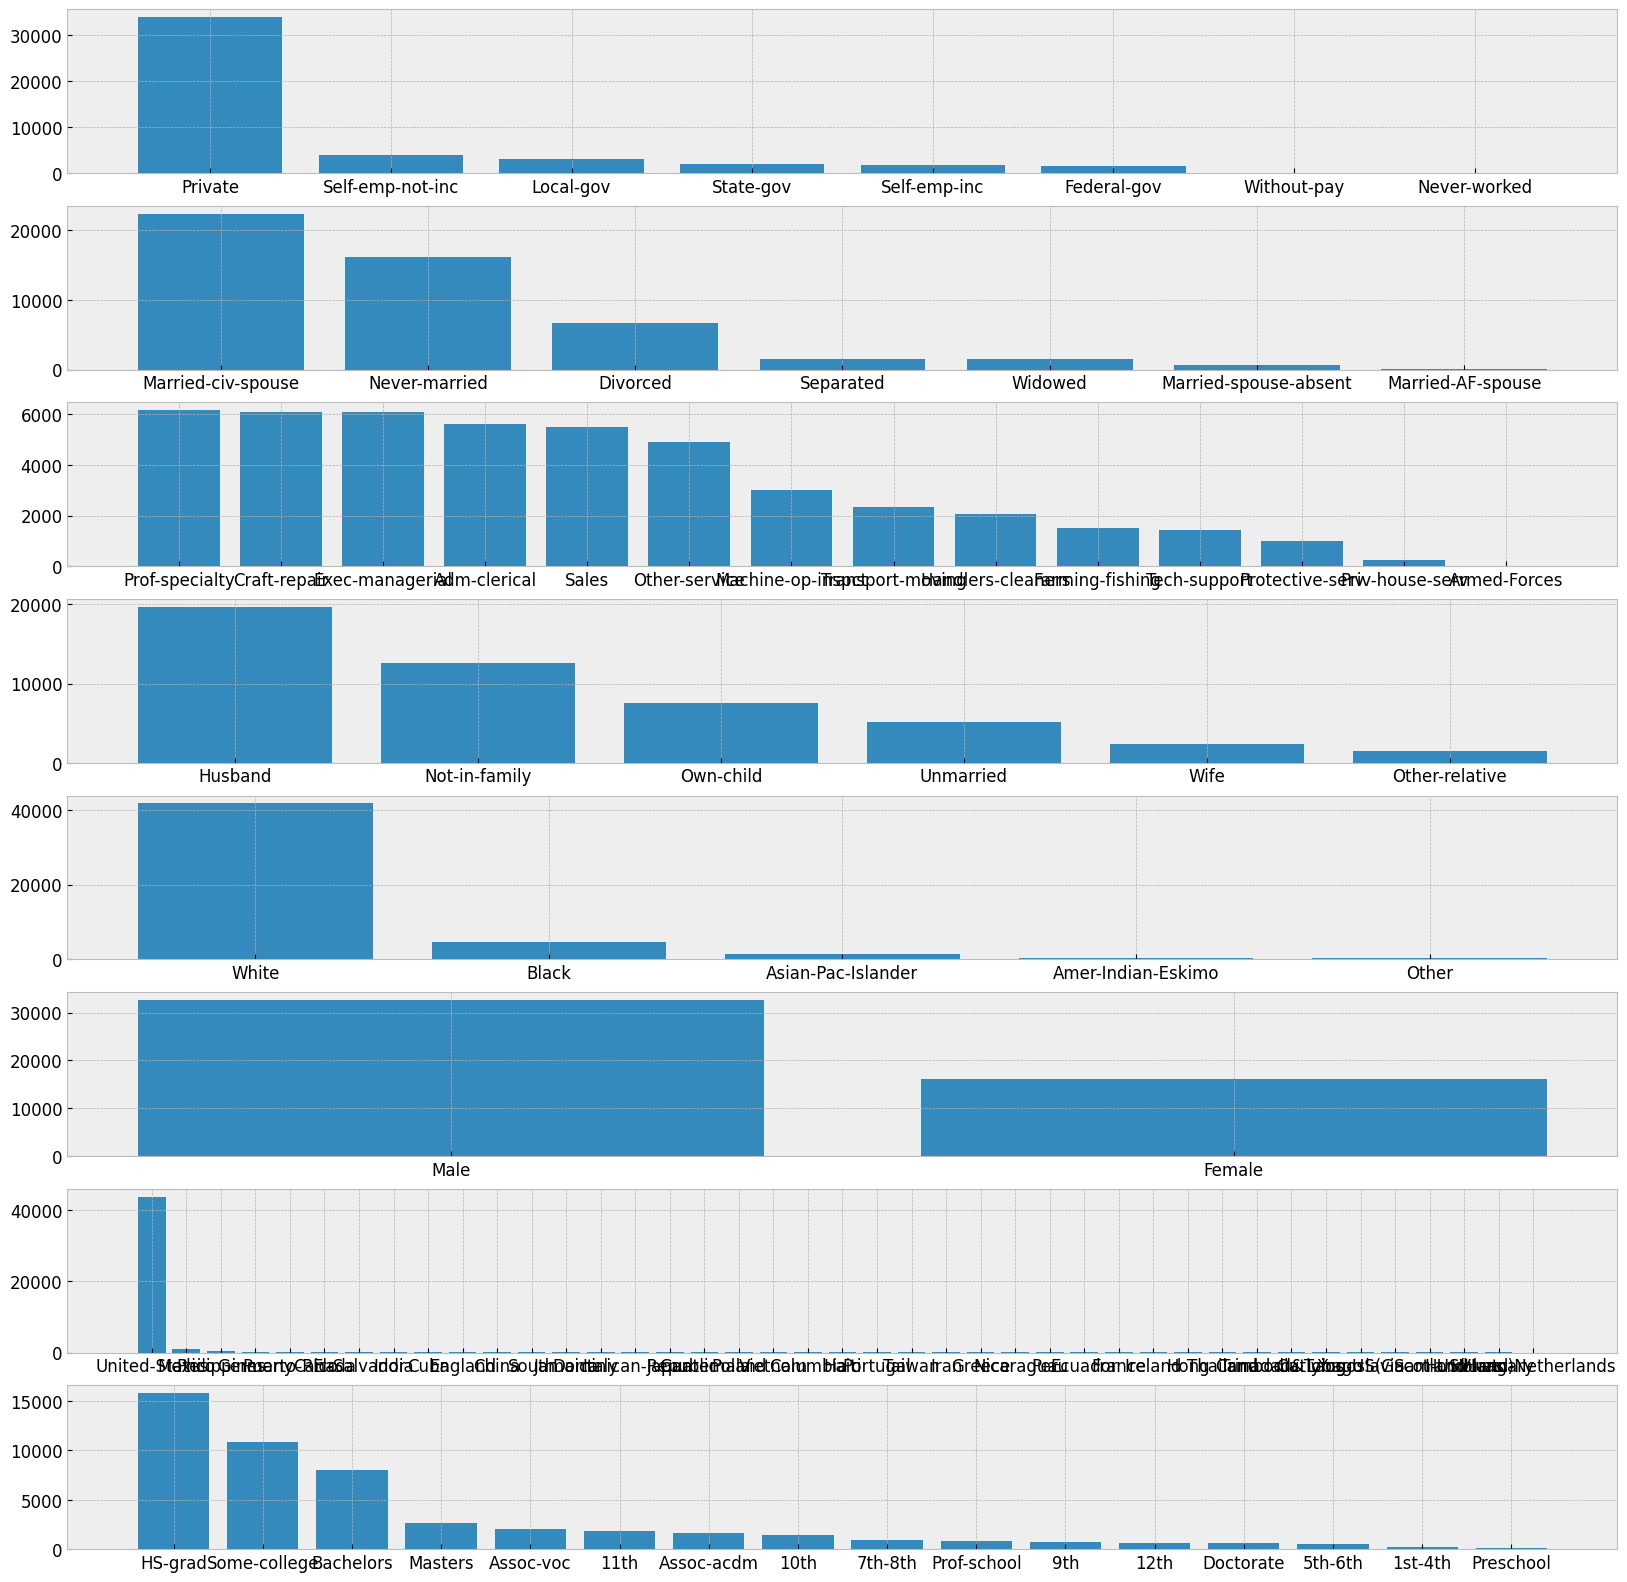

In [4]:
fig, axs = plt.subplots(8, figsize=(20,20))
axs[0].bar(adult['work-class'].value_counts().keys(), adult['work-class'].value_counts())
axs[1].bar(adult['marital-status'].value_counts().keys(), adult['marital-status'].value_counts())
axs[2].bar(adult['occupation'].value_counts().keys(), adult['occupation'].value_counts())
axs[3].bar(adult['relationship'].value_counts().keys(), adult['relationship'].value_counts())
axs[4].bar(adult['race'].value_counts().keys(), adult['race'].value_counts())
axs[5].bar(adult['sex'].value_counts().keys(), adult['sex'].value_counts())
axs[6].bar(adult['native-country'].value_counts().keys(), adult['native-country'].value_counts())
axs[7].bar(adult['education'].value_counts().keys(), adult['education'].value_counts())

In [5]:
train_set, test_set = train_test_split(adult, test_size= 0.2, random_state=32)

In [6]:
adult_X = train_set.drop('income', axis=1)
adult_y = train_set['income'].copy()

In [7]:
num_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
nominal_cat_features = ['work-class', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ordinal_cat_features = ['education']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

ordinal_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder())
])

nominal_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

full_pipeline = ColumnTransformer([
  ('num', num_pipeline, num_features),
  ('ordinal_cat', ordinal_cat_pipeline, ordinal_cat_features),
  ('nominal_cat', nominal_cat_pipeline, nominal_cat_features)
])

In [8]:
adult_prepared = full_pipeline.fit_transform(adult_X)

column_names = [ 
  feature
    .replace('num__', '')
    .replace('ord_cat__', '') 
    .replace('nom_cat__', '') 
  for feature in full_pipeline.get_feature_names_out()
]

# Transform the numpy n-dimensional array into a pandas dataframe
# Because the oneHotEncoder returned a sparse matrix, we needed to convert it to array when passing it to the 
# DataFrame constructor
adult_prepared = pd.DataFrame(data=adult_prepared.toarray(), columns=column_names, index=adult_X.index)
adult_prepared.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,ordinal_cat__education,nominal_cat__work-class_Federal-gov,nominal_cat__work-class_Local-gov,nominal_cat__work-class_Never-worked,...,nominal_cat__native-country_Portugal,nominal_cat__native-country_Puerto-Rico,nominal_cat__native-country_Scotland,nominal_cat__native-country_South,nominal_cat__native-country_Taiwan,nominal_cat__native-country_Thailand,nominal_cat__native-country_Trinadad&Tobago,nominal_cat__native-country_United-States,nominal_cat__native-country_Vietnam,nominal_cat__native-country_Yugoslavia
42252,-1.579908,-0.402593,-1.979955,-0.145687,-0.216166,-1.649610,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23934,-0.045792,4.689397,1.138223,-0.145687,-0.216166,1.178546,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9284,-1.141589,-0.753466,-0.031094,-0.145687,-0.216166,1.582568,15.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
43490,-1.214642,-0.411389,1.138223,-0.145687,-0.216166,-2.053632,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
42677,2.218857,-0.915899,-0.420866,-0.145687,-0.216166,-2.861676,11.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(adult_prepared, adult_y)

DummyClassifier(strategy='most_frequent')

In [10]:
dummy_classifier.score(adult_prepared, adult_y)

0.7594758528907429

In [11]:
scores = cross_val_score(
  dummy_classifier, adult_X, adult_y,
  scoring="roc_auc", cv=10)
print(
    f"Dummy Classifier  AUC: {scores.mean():.3f} STD: {scores.std():.2f}"
)

Dummy Classifier  AUC: 0.500 STD: 0.00


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

for model in [
    DummyClassifier,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
]:
    classifier_model = model()
    kfold = KFold(
        n_splits=10, random_state=42, shuffle=True
    )
    scores = cross_val_score(
        classifier_model,
        adult_prepared, 
        adult_y, 
        scoring="roc_auc", cv=kfold
    )
    print(
    f"{model.__name__:22}  AUC: {scores.mean():.3f} STD: {scores.std():.2f}"
)

DummyClassifier         AUC: 0.500 STD: 0.00
DecisionTreeClassifier  AUC: 0.751 STD: 0.01
RandomForestClassifier  AUC: 0.902 STD: 0.01
GradientBoostingClassifier  AUC: 0.920 STD: 0.00
BaggingClassifier       AUC: 0.883 STD: 0.01


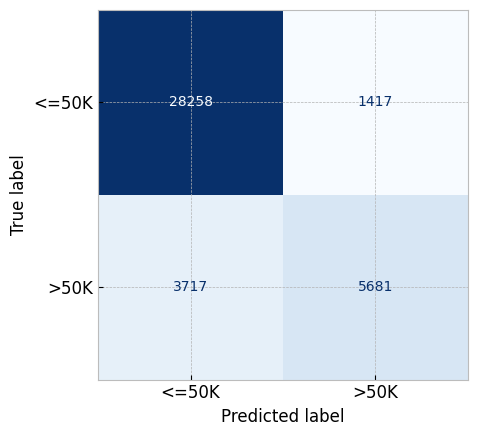

In [13]:
gbc = GradientBoostingClassifier()
gbc.fit(adult_prepared, adult_y)

metrics.ConfusionMatrixDisplay.from_estimator(
  estimator=gbc,
  X=adult_prepared, y=adult_y,
  cmap="Blues", colorbar=False
)
plt.show()

In [14]:
param_grid = {
    "learning_rate": [0.2],
    "max_depth":[5],
}
grid_search = GridSearchCV(
  estimator=GradientBoostingClassifier(),
  param_grid=param_grid,
  n_jobs=-1,
  scoring='roc_auc',
).fit(adult_prepared, adult_y)
print(f"Best Score: {grid_search.best_score_}")
print(f"Best Params: {grid_search.best_params_}")

Best Score: 0.9267614130251719
Best Params: {'learning_rate': 0.2, 'max_depth': 5}


In [15]:
adult_test_X = test_set.drop('income', axis=1)
adult_test_y = test_set['income'].copy()
transformed_test_set = full_pipeline.transform(adult_test_X)
column_names = [ 
  feature
    .replace('num__', '')
    .replace('cat_ordinal__', '') 
    .replace('cat_nominal__', '') 
  for feature in full_pipeline.get_feature_names_out()
]
adult_test_prepared = pd.DataFrame(transformed_test_set.toarray(), columns=column_names, index=adult_test_X.index)
scores = cross_val_score(
  gbc, adult_test_prepared, adult_test_y,
  scoring="roc_auc", cv=10)
print(
    f"Gradient Classifier  AUC: {scores.mean():.3f} STD: {scores.std():.2f}"
)

Gradient Classifier  AUC: 0.921 STD: 0.01


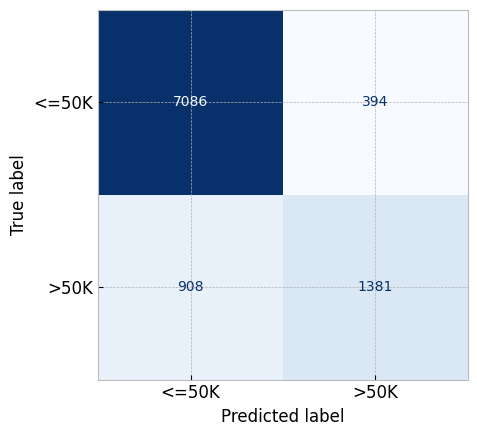

In [16]:
metrics.ConfusionMatrixDisplay.from_estimator(
  estimator=gbc,
  X=adult_test_prepared, y=adult_test_y,
  cmap="Blues", colorbar=False
)
plt.show()